# K-Means Clustering
Cluster splats using K-Means clustering.
This is the offline "oracle" version of the clustering.

In [2]:
# Path to the CSV file containing the collected splats.
DATA_NAME = "collected_splats"

# Number of clusters.
CLUSTERS = 12

In [3]:
import numpy as np
from data_handler import load_splats

from constants import IMAGE_HEIGHT, IMAGE_WIDTH

In [4]:
splats = load_splats(DATA_NAME)

# Cluster Splats
For each pixel,
1. Run k-means clustering on all splats.
2. Within each cluster, commutatively sum the alpha and color values.

In [5]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import os
from sklearn.cluster import KMeans

In [6]:
# Restrict the number of threads to 1 for kmeans.
os.environ['OMP_NUM_THREADS'] = '1'

In [7]:
def cluster_pixel(pixel_splats, clusters):
    """Compute clustering on a single pixel."""

    # Get depth values.
    depths = pixel_splats[:, 1]

    # Run K-Means clustering.
    kmeans = KMeans(n_clusters=clusters).fit(depths.reshape(-1, 1))

    # Initialize clustering 2D list: cluster -> [[alpha, depth, *color], ...].
    pixel_clustering = [[] for _ in range(clusters)]

    # Loop through each splat and place it in the appropriate cluster.
    for splat_index, cluster_index in enumerate(kmeans.labels_):
        pixel_clustering[cluster_index].append(pixel_splats[splat_index])

    # Commutatively combine cluster values [[median depth, alpha, color], ...].
    depth_clusters = np.empty((clusters, 5))
    for cluster_index, cluster_splats in enumerate(pixel_clustering):
        # Convert to numpy array.
        cluster_splats_array = np.array(cluster_splats)

        # Compute fields.
        depth_clusters[cluster_index, 0] = np.median(cluster_splats_array[:, 1])
        depth_clusters[cluster_index, 1] = 1 - np.prod(1 - cluster_splats_array[:, 0])
        alpha_sum = np.sum(cluster_splats_array[:, 0])
        if alpha_sum:
            depth_clusters[cluster_index, 2:] = np.sum(
                cluster_splats_array[:, 0].reshape(-1, 1) * cluster_splats_array[:, 2:],
                axis=0) / alpha_sum
        else:
            depth_clusters[cluster_index, 2:] = np.zeros(3)

    return depth_clusters[np.argsort(depth_clusters[:, 0])]


## Do the Clustering
1. Shuffle the splats in each pixel.
2. Cluster the splats.

In [8]:
# Shuffle the splats in each pixel.
rng = np.random.default_rng()
rng.shuffle(splats, axis=1)

In [9]:
# Cluster shuffled splats.
clustered_splats = Parallel(n_jobs=-1)(delayed(cluster_pixel)(pixel_splats, CLUSTERS) for pixel_splats in tqdm(splats))

  0%|          | 0/1051648 [00:00<?, ?it/s]

/Users/kenneth/Documents/School_GitHub/PLSE/clustering-exploration/venv/clustering-exploration/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid = os.fork()


# Compute Image From Clusters
Compute the final pixel color by alpha compositing the clusters.

In [10]:
def alpha_compose_pixel(pixel_clusters):
    # Define the transmittance and pixel color for the first cluster.
    transmittance = 1.0
    pixel_color = np.zeros(3)

    # Loop through remaining clusters.
    for _, cluster_alpha, *cluster_color in pixel_clusters:
        # Skip transparent cluster.
        if not cluster_alpha:
            continue

        # Exit once the transmittance is basically zero.
        if transmittance <= 0.001:
            break

        # Compute the pixel color.
        pixel_color += cluster_alpha * np.array(cluster_color) * transmittance

        # Compute the transmittance.
        transmittance *= 1 - min(1, cluster_alpha)

    # Return the computed pixel color.
    return pixel_color

In [11]:
computed_image = [alpha_compose_pixel(pixel_clusters) for pixel_clusters in tqdm(clustered_splats)]

  0%|          | 0/1051648 [00:00<?, ?it/s]

## Display the Computed Image



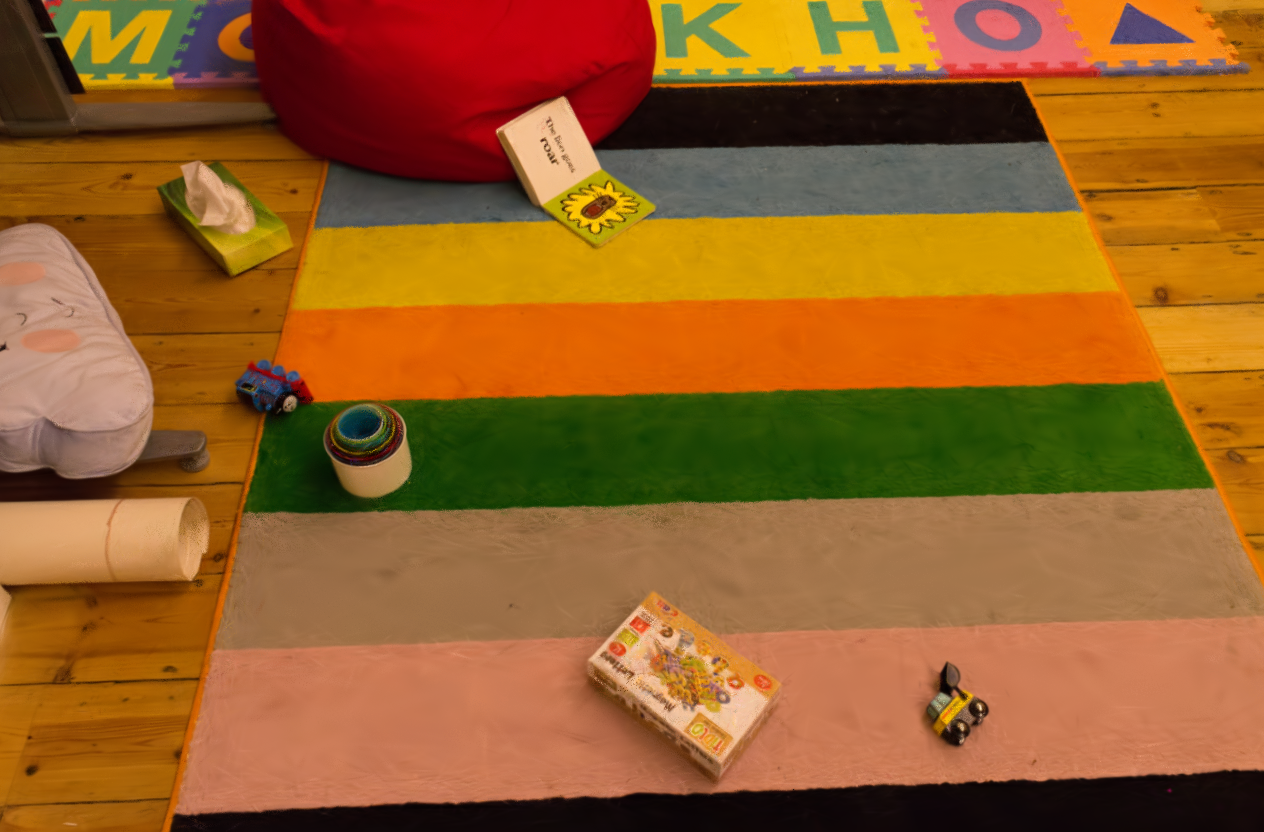

In [12]:
from image_handler import save_array_to_image
display(save_array_to_image(np.array(computed_image).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 3), f"k_means_clustering_k_{CLUSTERS}"))